In [ ]:
#pip install similaritymeasures

In [ ]:
#pip install tslearn

In [ ]:
#pip install frechetdist

In [ ]:
pip install trjtrypy

# Libraries

In [ ]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
import statsmodels.api as sm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from termcolor import colored
import matplotlib as mpl
from scipy import optimize
from sklearn.svm import LinearSVC
from termcolor import colored
from scipy.stats import entropy
import os
import ast
import csv
import json 
import scipy.io
import trjtrypy as tt
from trjtrypy.featureMappings import curve2vec
from trjtrypy.distances import d_Q_pi
#import similaritymeasures
#import tslearn
#from tslearn.metrics import dtw
#from scipy.spatial.distance import directed_hausdorff
#from frechetdist import frdist

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler
import torchvision.transforms as T

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Read car-bus data

In [ ]:
def read_file(file_name):
    data = []
    with open(file_name, "r") as f:
        for line in f:
            item = line.strip().split(",")
            data.append(np.array(item))
    return np.array(data)

data1 = read_file('/content/gdrive/My Drive/Colab Notebooks/go_track_tracks.csv')[1:,:-1]
data2 = read_file('/content/gdrive/My Drive/Colab Notebooks/go_track_trackspoints.csv')[1:,1:4]

float1 = np.vectorize(float)
int1 = np.vectorize(int)
track_id = int1(data1[:,0])
labels = np.where(int1(data1[:,-1]) < 1.5, int1(data1[:,-1]), -1) 
traj = float1(data2)

sum(labels==1), sum(labels==-1)

In [ ]:
trajec = [0] * 163

for i in range(163):
    trajec[i] = []
    I = np.where(traj[:,2] == track_id[i])
    trajec[i] = np.array([labels[i], traj[I]], dtype = 'object')

trajec = np.array(trajec)

trajectory = [0] * 163
trajectory_label_id = [0] * 163

for i in range(163):
    trajectory[i] = trajec[i][1][:,:2]
    trajectory_label_id[i] = np.array([trajec[i][1][:,:2], trajec[i][0], 
                                       trajec[i][1][:,2][0]], dtype = 'object')
    
trajectory_label_id = np.array(trajectory_label_id, dtype = 'object')
trajectory = np.array(trajectory, dtype = 'object')

min_length = 10
max_length = 1000 #160 for balance data
l = 0
index = [] 
for i in range(163):
    if len(trajectory[i]) < min_length or len(trajectory[i]) > max_length:
        l = l + 1
    else:
        index.append(i)
        
l, 163-l

In [ ]:
trajectories = [0] * (163-l)
trajectories_label_id = [0] * (163-l)

j = 0
for i in range(163):
    if len(trajectory[i]) >= min_length and len(trajectory[i]) <= max_length:
        trajectories[j] = np.array(trajectory[i])
        trajectories_label_id[j] = trajectory_label_id[i]
        j = j + 1

trajectories_label_id = np.array(trajectories_label_id, dtype = 'object')
trajectories = np.array(trajectories, dtype = 'object')

cars = trajectories_label_id[np.where(trajectories_label_id[:,1] == 1)][:,:2][:,0]
buses = trajectories_label_id[np.where(trajectories_label_id[:,1] == -1)][:,:2][:,0]

cars_copy = cars.copy()
buses_copy = buses.copy()
len(cars), len(buses)

(78, 45)

In [ ]:
def remove_segments(traj): # removes stationary points
    p2 = traj[1:]
    p1 = traj[:-1]
    L = ((p2-p1)*(p2-p1)).sum(axis =1)
    I = np.where(L>1e-16)[0]
    return traj[I]

In [ ]:
cars = np.array(list(map(remove_segments, cars)), dtype='object')
buses = np.array(list(map(remove_segments, buses)), dtype='object')

I = np.where(np.array([len(cars[i]) for i in range(len(cars))]) > 1)
J = np.where(np.array([len(buses[i]) for i in range(len(buses))]) > 1)

cars = cars[I]
buses = buses[J]

cars_copy = cars.copy()
buses_copy = buses.copy()
print("len(cars), len(buses)=", len(cars), len(buses))

len(cars), len(buses)= 78 45


In [ ]:
a = np.arange(len(cars))
I = np.where((a != 28) & (a != 29))
cars = cars[I]
buses = buses[:-1]
len(cars), len(buses)

(76, 44)

Original car-bus


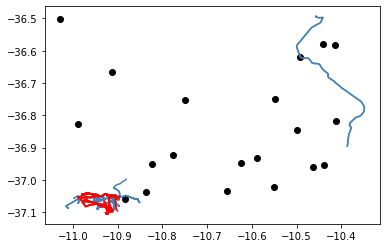

In [ ]:
a, c = np.min((np.min([np.min(cars[i], axis=0) for i in range(len(cars))], axis=0), 
       np.min([np.min(buses[i], axis=0) for i in range(len(buses))], axis=0)), axis=0)
  
b, d = np.max((np.max([np.max(cars[i], axis=0) for i in range(len(cars))], axis=0), 
               np.max([np.max(buses[i], axis=0) for i in range(len(buses))], axis=0)), axis=0)

m = 20
Q = np.ones((m,2))

Q[:,0] = (b - a + 0.001) * np.random.random_sample(m) + a - 0.02
Q[:,1] = (d - c + 0.001) * np.random.random_sample(m) + c - 0.01

for i in range(len(cars)):
    plt.plot(cars[i][:,0], cars[i][:,1], color = "steelblue");
for i in range(len(buses)):
    plt.plot(buses[i][:,0], buses[i][:,1], color = "r");
plt.scatter(Q[:,0], Q[:,1], color = "black")
print(colored(f'Original car-bus', 'yellow'))
plt.show()

# Classifiers and get_mu function

In [ ]:
CC = [100, 100, 10]
number_estimators = [50, 50]


clf0 = [make_pipeline(LinearSVC(dual=False, C=CC[0], tol=1e-5, 
                               class_weight ='balanced', max_iter=1000)), 
        "SVM, LinearSVC, C = "+str(CC[0])]
clf1 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[1], kernel='rbf', gamma='auto', max_iter=200000)),
        "Gaussian SVM, C="+str(CC[1])+", gamma=auto"]
clf2 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[2], kernel='poly', degree=3, max_iter=400000)),
        "Poly kernel SVM, C="+str(CC[2])+", deg=auto"]
clf3 = [DecisionTreeClassifier(), "Decision Tree"]
clf4 = [RandomForestClassifier(n_estimators=number_estimators[0]), 
         "RandomForestClassifier, n="+str(number_estimators[0])]
clf5 = [KNeighborsClassifier(n_neighbors=5), "KNN"]
clf6 = [LogisticRegression(solver='newton-cg'), "Logistic Regression"]

clf = [clf0, clf1, clf2, clf3, clf4, clf5, clf6]
classifs = [item[0] for item in clf]
keys = [item[1] for item in clf]

In [ ]:
def get_mu(data_1, data_2):
    a = np.mean([np.mean(data_1[i], 0) for i in range(len(data_1))], 0)
    b = np.mean([np.mean(data_2[i], 0) for i in range(len(data_2))], 0)
    c = abs(a-b)
    return max(c)

# The following 3 blocks are run and stored and fixed. We should not run it again. 

# Read the fixed datasets data_1 and data_2 from gdrive

In [ ]:
data_1 = []
data_2 = []
for i in range(226):
    path = '/Users/hasan/Desktop/Classifying-Spatial-Trajectories-main/Simulated_Car_Bus_data/data_1/'+str(i)+'.csv'
    #path = '/content/gdrive/My Drive/car-bus-generated/data_1/'+str(i)+'.csv'
    data_1.append(np.array(pd.read_csv(path, header=None)))

for i in range(220):
    path = '/Users/hasan/Desktop/Classifying-Spatial-Trajectories-main/Simulated_Car_Bus_data/data_2/'+str(i)+'.csv'
    #path = '/content/gdrive/My Drive/car-bus-generated/data_2/'+str(i)+'.csv'
    data_2.append(np.array(pd.read_csv(path, header=None)))

data_1 = np.array(data_1, dtype = "object")
data_2 = np.array(data_2, dtype = "object")
print("data_1.shape, data_2.shape=", data_1.shape, data_2.shape)

data_1.shape, data_2.shape= (226,) (220,)


## Plot data

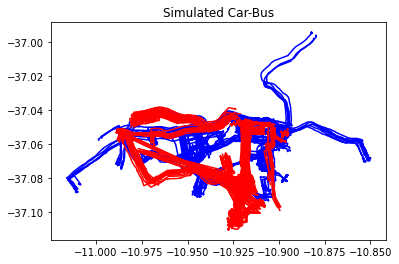

In [ ]:
for i in range(len(data_1)):
    if data_1[i][0][0] < -10.7:
        plt.plot(data_1[i][:,0], data_1[i][:,1], color='blue')
for i in range(len(data_2)):
    plt.plot(data_2[i][:,0], data_2[i][:,1], color='red')
plt.title('Simulated Car-Bus')
plt.savefig(f'/Users/hasan/Desktop/Anaconda/Research/Pictures for 2ed paper/Simulated Car-Bus data.png', 
            bbox_inches='tight', dpi=200)
plt.show()

# Classification with feature mappings $v_Q$, $v_Q^{\exp}$, $v_Q^{\varsigma}$ with 20 random landmarks, and endpoints

In [ ]:
from google.colab import files
files.upload()

import v_Q_mu_endpoints_classification
from v_Q_mu_endpoints_classification import binaryClassificationAverageMajority

Saving v_Q_mu_endpoints_classification.py to v_Q_mu_endpoints_classification.py


### Boost($v_Q$), Boost($v_Q^{\varsigma}$), Boost($v_Q^{\exp}$) with epoch=50 and num_trials_maj=11

In [ ]:
classifs = binaryClassificationAverageMajority(data_1, data_2, 
            Q_size=20, epoch=50, num_trials_maj=11, classifiers=clf,
            version='unsigned', test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 206.8452913761139
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1536      0.1716     0.0252
2  Gaussian SVM, C=100, gamma=auto       0.0571      0.0675     0.0224
3  Poly kernel SVM, C=10, deg=auto       0.3012      0.3109     0.1131
4                    Decision Tree       0.0000      0.0678     0.0196
5     RandomForestClassifier, n=50       0.0000      0.0536     0.0186
6                              KNN       0.0518      0.0858     0.0271
7              Logistic Regression       0.4237      0.4452     0.0522
test_errors: 
 [0.1716, 0.0675, 0.3109, 0.0678, 0.0536, 0.0858, 0.4452]
std_test_errors: 
 [0.0252, 0.0224, 0.1131, 0.0196, 0.0186, 0.0271, 0.0522]


In [ ]:
classifs = binaryClassificationAverageMajority(data_1, data_2, 
            Q_size=20, epoch=50, num_trials_maj=11, classifiers=clf,
            version='signed', sigma=1, test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 395.5197982788086
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3004      0.3733     0.0423
2  Gaussian SVM, C=100, gamma=auto       0.0071      0.1142     0.0300
3  Poly kernel SVM, C=10, deg=auto       0.1111      0.2836     0.0379
4                    Decision Tree       0.0000      0.1027     0.0251
5     RandomForestClassifier, n=50       0.0000      0.0872     0.0222
6                              KNN       0.1120      0.2175     0.0318
7              Logistic Regression       0.3962      0.4324     0.0398
test_errors: 
 [0.3733, 0.1142, 0.2836, 0.1027, 0.0872, 0.2175, 0.4324]
std_test_errors: 
 [0.0423, 0.03, 0.0379, 0.0251, 0.0222, 0.0318, 0.0398]


In [ ]:
classifs = binaryClassificationAverageMajority(data_1, data_2, Q_size=20, epoch=50, 
                                num_trials_maj=11, classifiers=clf, test_size=0.3)
A = classifs.classification_v_Q_mu()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 208.6015214920044
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1892      0.2082     0.0383
2  Gaussian SVM, C=100, gamma=auto       0.0504      0.0887     0.0395
3  Poly kernel SVM, C=10, deg=auto       0.1071      0.1384     0.0388
4                    Decision Tree       0.0001      0.0781     0.0230
5     RandomForestClassifier, n=50       0.0000      0.0622     0.0213
6                              KNN       0.0483      0.0888     0.0276
7              Logistic Regression       0.2146      0.2321     0.0386
test_errors: 
 [0.2082, 0.0887, 0.1384, 0.0781, 0.0622, 0.0888, 0.2321]
std_test_errors: 
 [0.0383, 0.0395, 0.0388, 0.023, 0.0213, 0.0276, 0.0386]


### Rand $v_Q$, Rand $v_Q^{\varsigma}$, Rand $v_Q^{\exp}$ with epoch=50 and num_trials_maj=1

In [ ]:
classifs = binaryClassificationAverageMajority(data_1, data_2, Q_size=20, 
                                    epoch=50, num_trials_maj=1, classifiers=clf, 
                                    version='unsigned', test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 20.545374155044556
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1771      0.1960     0.0418
2  Gaussian SVM, C=100, gamma=auto       0.0667      0.0851     0.0237
3  Poly kernel SVM, C=10, deg=auto       0.3065      0.3219     0.1057
4                    Decision Tree       0.0000      0.1128     0.0237
5     RandomForestClassifier, n=50       0.0004      0.0660     0.0207
6                              KNN       0.0509      0.0861     0.0231
7              Logistic Regression       0.4064      0.4252     0.0482
test_errors: 
 [0.196, 0.0851, 0.3219, 0.1128, 0.066, 0.0861, 0.4252]
std_test_errors: 
 [0.0418, 0.0237, 0.1057, 0.0237, 0.0207, 0.0231, 0.0482]


In [ ]:
classifs = binaryClassificationAverageMajority(data_1, data_2, Q_size=20, 
                                    epoch=50, num_trials_maj=1, classifiers=clf, 
                                    version='signed', sigma=1, test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 37.645344734191895
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3334      0.3991     0.0433
2  Gaussian SVM, C=100, gamma=auto       0.0131      0.1555     0.0303
3  Poly kernel SVM, C=10, deg=auto       0.1607      0.3143     0.0456
4                    Decision Tree       0.0000      0.1503     0.0312
5     RandomForestClassifier, n=50       0.0001      0.0975     0.0263
6                              KNN       0.1641      0.2488     0.0448
7              Logistic Regression       0.4060      0.4182     0.0452
test_errors: 
 [0.3991, 0.1555, 0.3143, 0.1503, 0.0975, 0.2488, 0.4182]
std_test_errors: 
 [0.0433, 0.0303, 0.0456, 0.0312, 0.0263, 0.0448, 0.0452]


In [ ]:
classifs = binaryClassificationAverageMajority(data_1, data_2, Q_size=20, 
                    epoch=50, num_trials_maj=1, classifiers=clf, test_size=0.3)
A = classifs.classification_v_Q_mu()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 21.113221645355225
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2440      0.2649     0.0567
2  Gaussian SVM, C=100, gamma=auto       0.1032      0.1443     0.0752
3  Poly kernel SVM, C=10, deg=auto       0.1903      0.2158     0.0789
4                    Decision Tree       0.0058      0.1257     0.0500
5     RandomForestClassifier, n=50       0.0073      0.0918     0.0483
6                              KNN       0.0968      0.1519     0.0556
7              Logistic Regression       0.2760      0.2864     0.0628
test_errors: 
 [0.2649, 0.1443, 0.2158, 0.1257, 0.0918, 0.1519, 0.2864]
std_test_errors: 
 [0.0567, 0.0752, 0.0789, 0.05, 0.0483, 0.0556, 0.0628]


In [ ]:
classifs = binaryClassificationAverageMajority(data_1, data_2, Q_size=20, 
                                               epoch=50, num_trials_maj=1, 
                                               classifiers=clf, test_size=0.3)
A = classifs.endpoint_classification()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 6.815916299819946
Number of trials = 50
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3844      0.4013     0.0378
2  Gaussian SVM, C=100, gamma=auto       0.0576      0.0697     0.0229
3  Poly kernel SVM, C=10, deg=auto       0.1932      0.2075     0.0422
4                    Decision Tree       0.0000      0.0967     0.0278
5     RandomForestClassifier, n=50       0.0003      0.0649     0.0224
6                              KNN       0.0548      0.0916     0.0231
7              Logistic Regression       0.4851      0.5096     0.0312
test_errors: 
 [0.4013, 0.0697, 0.2075, 0.0967, 0.0649, 0.0916, 0.5096]
std_test_errors: 
 [0.0378, 0.0229, 0.0422, 0.0278, 0.0224, 0.0231, 0.0312]


# Classification with Perceptron-Like algorithm

In [ ]:
from google.colab import files
files.upload()

import Perceptron_Like_Algo_Class
from Perceptron_Like_Algo_Class import classification

Saving Perceptron_Like_Algo_Class.py to Perceptron_Like_Algo_Class.py


In [ ]:
classif = classification(data_1, data_2, Q_size=20, model="GSVM", C=50, gamma='auto', 
                        classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                        std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 5038.1972715854645
               Classifier  Train Error  Test Error  Std Error
1  GSVM, C=50, gamma=auto       0.0308      0.0409     0.0161
mu = 0.006627883067677587


In [ ]:
for Model in ['GSVM']:
    classif = classification(data_1, data_2, Q_size=20, model=Model, C=50, gamma='auto', 
                         classifiers=[], epoch=50, maj_num=1, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")

total time = 457.7047817707062
               Classifier  Train Error  Test Error  Std Error
1  GSVM, C=50, gamma=auto       0.0425      0.0763     0.0505
mu = 0.00698033136641385


## Boost(MD $v_Q^{\exp}$) with epoch=50, maj_num=11 and init_iter=3 (done)

In [ ]:
classif = classification(data_1, data_2, Q_size=20, model="LSVM", C=100, gamma='auto', 
                        classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                        std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 4746.919735431671
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.1179      0.1573     0.0435
mu = 0.009044327988442902


In [ ]:
classif = classification(data_1, data_2, Q_size=20, model="GSVM", C=100, gamma='auto', 
                        classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                        std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 4915.284518957138
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.0276      0.0464     0.0186
mu = 0.012944978681531438


In [ ]:
classif = classification(data_1, data_2, Q_size=20, model="PSVM", C=100, gamma='auto', 
                        classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                        std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 5206.133144855499
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0285       0.053     0.0323
mu = 0.006150686797532501


In [ ]:
classif = classification(data_1, data_2, Q_size=20, model="DT", C=100, gamma='auto', 
                        classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                        std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 4621.400712490082
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.0888     0.0237
mu = 0.007961809637579975


In [ ]:
classif = classification(data_1, data_2, Q_size=20, model="RF", C=100, gamma='auto', 
                        classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                        std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 7676.988169193268
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.0578     0.0225
mu = 0.007203855994584174


In [ ]:
classif = classification(data_1, data_2, Q_size=20, model="KNN", C=100, gamma='auto', 
                        classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                        std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 5359.562419176102
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.0438      0.0733     0.0292
mu = 0.0036828466577887298


In [ ]:
classif = classification(data_1, data_2, Q_size=20, model="LR", C=100, gamma='auto', 
                        classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                        std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 5055.334633588791
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.1972      0.2207     0.0365
mu = 0.0027013250247058807


## MD $v_Q^{\exp}$ with epoch=50, maj_num=1 and init_iter=3 (done)

In [ ]:
for Model in ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR']:
    classif = classification(data_1, data_2, Q_size=20, model=Model, C=100, gamma='auto', 
                         classifiers=[], epoch=50, maj_num=1, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")

total time = 425.5162479877472
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.1678      0.1993      0.039
mu = 0.010849009673730592
total time = 451.386381149292
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.0357      0.0682     0.0338
mu = 0.006653255655386658


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 456.87237906455994
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0376      0.0658     0.0388
mu = 0.009507268404643554
total time = 432.4383804798126
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.1266       0.03
mu = 0.0088029167377357
total time = 713.6568853855133
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0001      0.0752     0.0277
mu = 0.012544938194402278
total time = 465.11791729927063
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.0609      0.1069     0.0398
mu = 0.005444417188378736
total time = 439.68623328208923
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.2428      0.2673     0.0523
mu = 0.01209906296380403


# KNN with $d_Q^{\pi}$ and DTW

## KNN with $d_Q^{\pi}$ distance with matrix storing method

### Calculate distance matrix

In [ ]:
def calculate_dists_d_Q_pi(data1, data2, p, path): 
    start_time = time.time() 
    data = np.concatenate((data1, data2), 0)
    n = len(data)
    A = []
    for i in range(n-1):
        for j in range(i+1, n):
            A.append(d_Q_pi(Q, data[i], data[j], p=p))
    A = np.array(A)
    tri = np.zeros((n, n))
    tri[np.triu_indices(n, 1)] = A
    for i in range(1, n):
        for j in range(i):
            tri[i][j] = tri[j][i]
    np.savetxt(path, tri, delimiter=',')

    total_time = time.time() - start_time
    return total_time

In [ ]:
path = '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (simulated-car-bus)/d_Q_pi.csv'
calculate_dists_d_Q_pi(data_1, data_2, p=1, path=path)

183.61090755462646

In [ ]:
def KNN_with_dists_d_Q_pi(n_1, n_2, path_to_dists):
    '''path example: '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/d_Q_pi.csv'
       path_to_dists: the path to the corresponding distance matrix
       n_1: len(data_1)
       n_2: len(data_2)'''

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1] * n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)

    dist_matrix = np.array(pd.read_csv(path_to_dists,  header=None))

    D_train = dist_matrix[I][:, I]
    D_test = dist_matrix[J][:,I]
    train_labels = labels[I]
    test_labels = labels[J]

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(train_labels))

    #Predict labels for train dataset
    train_pred = clf.predict(D_train)
    train_error = sum(train_labels != train_pred)/len(I)
    
    #Predict labels for test dataset
    test_pred = clf.predict(D_test)
    test_error = sum((test_labels != test_pred))/len(J)
        
    return train_error, test_error

In [ ]:
def KNN_average_error_d_Q_pi(data1, data2, num_trials, path_to_dists):

    '''path_to_dists: the path to the corresponding distance matrix'''

    Start_time = time.time()

    train_errors = np.zeros(num_trials)
    test_errors = np.zeros(num_trials)

    for i in range(num_trials):
        train_errors[i], test_errors[i] = KNN_with_dists_d_Q_pi(len(data1), len(data2), path_to_dists)

    Dict = {}
    Dict[1] = [f"KNN with d_Q_pi", 
                    np.round(np.mean(train_errors), decimals = 4), 
                    np.round(np.mean(test_errors), decimals = 4), 
                    np.round(np.std(test_errors), decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return (df, np.mean(train_errors), np.mean(test_errors), np.std(test_errors))

In [ ]:
path = '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (simulated-car-bus)/d_Q_pi.csv'
KNN_average_error_d_Q_pi(data_1, data_2, num_trials=50, path_to_dists=path)

num_trials = 50
total time = 6.035728454589844


(        Classifier  Train Error  Test Error     std
 1  KNN with d_Q_pi       0.0601       0.107  0.0271,
 0.06012820512820514,
 0.10701492537313433,
 0.027097260529064474)

## KNN with DTW from tslearn by saving matrx method

### Calculate distance matrix

In [ ]:
def calculate_dists_dtw_tslearn(data1, data2, path): 
    start_time = time.time() 
    data = np.concatenate((data1, data2), 0)
    n = len(data)
    A = []
    for i in range(n-1):
        for j in range(i+1, n):
            A.append(tslearn.metrics.dtw(data[i], data[j]))
    A = np.array(A)
    tri = np.zeros((n, n))
    tri[np.triu_indices(n, 1)] = A
    for i in range(1, n):
        for j in range(i):
            tri[i][j] = tri[j][i]
    np.savetxt(path, tri, delimiter=',')

    total_time = time.time() - start_time
    return total_time

In [ ]:
path = '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (simulated-car-bus)/dtw-tslearn.csv'
calculate_dists_dtw_tslearn(data_1, data_2, path=path)

77.92436957359314

In [ ]:
def KNN_with_dists_dtw_tslearn(n_1, n_2, path_to_dists):
    '''path example: '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/sspd.csv'
       path_to_dists: the path to the corresponding distance matrix
       n_1: len(data_1)
       n_2: len(data_2)'''

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1] * n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)

    dist_matrix = np.array(pd.read_csv(path_to_dists,  header=None))

    D_train = dist_matrix[I][:, I]
    D_test = dist_matrix[J][:,I]
    train_labels = labels[I]
    test_labels = labels[J]

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(train_labels))

    #Predict labels for train dataset
    train_pred = clf.predict(D_train)
    train_error = sum(train_labels != train_pred)/len(I)
    
    #Predict labels for test dataset
    test_pred = clf.predict(D_test)
    test_error = sum((test_labels != test_pred))/len(J)
        
    return train_error, test_error

In [ ]:
def KNN_average_error_dtw_tslearn(data1, data2, num_trials, path_to_dists):

    '''path_to_dists: the path to the corresponding distance matrix'''

    Start_time = time.time()

    train_errors = np.zeros(num_trials)
    test_errors = np.zeros(num_trials)

    for i in range(num_trials):
        train_errors[i], test_errors[i] = KNN_with_dists_dtw_tslearn(len(data1), len(data2), path_to_dists)

    Dict = {}
    Dict[1] = [f"KNN with dtw from tslearn", 
                    np.round(np.mean(train_errors), decimals = 4), 
                    np.round(np.mean(test_errors), decimals = 4), 
                    np.round(np.std(test_errors), decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return (df, np.mean(train_errors), np.mean(test_errors), np.std(test_errors))

In [ ]:
path = '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (simulated-car-bus)/dtw-tslearn.csv'

G = KNN_average_error_dtw_tslearn(data_1, data_2, num_trials=50, path_to_dists=path)
G[0]

num_trials = 50
total time = 6.171208143234253


,Classifier,Train Error,Test Error,std
1,KNN with dtw from tslearn,0.0619,0.113,0.036


# Neural Networks (CNN)

## Helper functions

In [ ]:
from collections import Counter

def find_majority(votes):
    vote_count = Counter(votes)
    top = vote_count.most_common(1)
    return top[0][0]

def find_majority_array(A): # column-wise majority
    return list(map(find_majority, A.T))

def ExpCurve2Vec(points, curves, mu):
    D = tt.distsbase.DistsBase()
    a = np.array([np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves])
    return a

def get_mu(data_1, data_2):
    a = np.mean([np.mean(data_1[i], 0) for i in range(len(data_1))], 0)
    b = np.mean([np.mean(data_2[i], 0) for i in range(len(data_2))], 0)
    c = abs(a-b)
    return max(c)

def get_endpoints(data):
    n = len(data)
    data_endpoints = np.zeros((n, 4))
    for i in range(n):
        data_endpoints[i] = np.concatenate((data[i][0], data[i][-1]), 0)
    return data_endpoints

def train_test(data_1, data_2, test_size=0.3):
    
    n_1 = len(data_1)
    n_2 = len(data_2) 
    train_idx_1, test_idx_1, train_label_1, test_label_1 \
        = train_test_split(np.arange(n_1), [1] * n_1, test_size = test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test_split(np.arange(n_2), [0] * n_2, test_size = test_size)

    return train_idx_1, test_idx_1, train_label_1, test_label_1, \
                train_idx_2, test_idx_2, train_label_2, test_label_2

def train_test_mu(data_1, data_2, test_size=0.3):
    
    n_1 = len(data_1)
    n_2 = len(data_2) 
    
    train_idx_1, test_idx_1, train_label_1, test_label_1 \
        = train_test_split(np.arange(n_1), [1] * n_1, test_size=test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test_split(np.arange(n_2), [0] * n_2, test_size=test_size)

    train_1 = data_1[train_idx_1]
    train_2 = data_2[train_idx_2]
    test_1 = data_1[test_idx_1]
    test_2 = data_2[test_idx_2]

    arr1 = np.arange(len(train_1)+len(train_2))
    I_1 = np.random.shuffle(arr1)

    arr2 = np.arange(len(test_1)+len(test_2))
    I_2 = np.random.shuffle(arr2)
    
    train = np.concatenate((train_1, train_2), 0)[arr1[I_1]]
    train_labels = np.concatenate((train_label_1, train_label_2), 0)[arr1[I_1]]
    test = np.concatenate((test_1, test_2), 0)[arr2[I_2]]
    test_labels = np.concatenate((test_label_1, test_label_2), 0)[arr2[I_2]]

    a = np.mean([np.mean(train_1[i], 0) for i in range(len(train_1))], 0)
    b = np.mean([np.mean(train_2[i], 0) for i in range(len(train_2))], 0)
    mu = max(abs(a-b))
    
    return mu, train[0], test[0], train_labels[0], test_labels[0]

def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

## CNN for $v_Q$, $v_Q^{\varsigma}$, $v_Q^{exp}$, endpoints

In [ ]:
def neuralNetworkClassificationCNN(data_1, data_2, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-3, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 10, 
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3):
    
    """ 
    in_channels: the dimension of hidden layer
    D_out: output dimension
    version: 'signed' or 'unsigned' or 'exp' 
    stride: should be fixed to 1
    """

    start_time = time.time()

    train_errors = np.zeros(epoch)
    test_errors = np.zeros(epoch)

    losses = torch.zeros(epoch, num_trials_maj, Num_updates)
    
    for s in range(epoch):

        mu, train, test, train_labels, test_labels = train_test_mu(data_1, data_2, test_size)

        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()
        
        x_preds = torch.zeros(num_trials_maj, len(train))
        y_preds = torch.zeros(num_trials_maj, len(test))

        Min = np.min([np.min(train[i], 0) for i in range(len(train))], 0)
        Max = np.max([np.max(train[i], 0) for i in range(len(train))], 0)
        Mean = np.mean([np.mean(train[i], 0) for i in range(len(train))], 0)
        Std = np.std([np.std(train[i], 0) for i in range(len(train))], 0)
        
        for t in range(num_trials_maj):
            Q = np.ones((Q_size, 2))
            Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], Q_size)
            Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], Q_size)

            if (version == 'unsigned' or version == 'signed'):
                train_data = curve2vec(Q, train, version = version, sigma = sigma)
                test_data = curve2vec(Q, test, version = version, sigma = sigma)
            elif version == 'exp':
                train_data = ExpCurve2Vec(Q, train, mu)
                test_data = ExpCurve2Vec(Q, test, mu)
            elif version == 'endpoints':
                train_data = get_endpoints(train)
                test_data = get_endpoints(test)
            
            model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                                nn.ReLU(),
                                #nn.LeakyReLU(0.01),
                                #nn.Tanh(),
                                Flatten(),
                                nn.Linear(out_channels * (len(train_data[0]) - kernel_size + 1 + 2 * padding), 
                                            D_out)
                                )
    
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
            
            train_data = torch.from_numpy(train_data).float()
            test_data = torch.from_numpy(test_data).float()

            train_data = train_data.view(len(train_data), 1, len(train_data[0]))
            
            for k in range(Num_updates):
                x_pred = model(train_data) # of shape (N, D_out)
                loss = loss_fn(x_pred, train_labels)
                losses[s, t, k] = loss
                    
                if (k+1) % 1000 == 0:
                    optimizer.param_groups[0]['lr'] = lr_decay * learning_rate

                optimizer.zero_grad()

                loss.backward() # Backward pass

                optimizer.step()  # Calling the step function on the Optimizer 
                
            x_preds[t] = torch.argmax(model(train_data), axis=1)
            test_data = test_data.view(len(test_data), 1, len(test_data[0]))        
            y_preds[t] = torch.argmax(model(test_data), axis=1)
        
        x_preds = torch.tensor(find_majority_array(x_preds))
        y_preds = torch.tensor(find_majority_array(y_preds))
        
        train_errors[s] = sum(abs(train_labels - x_preds))/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds))/len(test_labels)

    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    plt.plot((torch.mean(losses, dim=(0,1))).detach().numpy())
    plt.show()

    Dict = {"CNN 1-Layer": [out_channels, learning_rate, 
               np.round(train_error_mean, decimals=4), 
                np.round(test_error_mean, decimals=4),
                np.round(test_error_std, decimals=4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                columns=['Channel 1', 'Learning Rate', 'Train Error', 
                         'Test Error', 'Std Error'])
    
    print(colored(f"total time = {time.time() - start_time}", "red"))

    return pdf

## num_maj = 1

### Endpoints

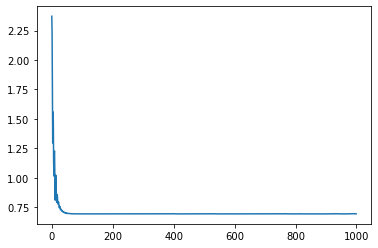

total time = 51.02600288391113


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.4944,0.4949,0.0075


In [ ]:
neuralNetworkClassificationCNN(data_1, data_2, Q_size = 20, lr_decay = 0.9, 
                               learning_rate = 1e-2, num_trials_maj = 1, 
                               out_channels = 10, kernel_size = 2, padding = 1, 
                               bias = True, Num_updates = 1000, D_out = 2, epoch = 50,
                               version = 'endpoints', sigma = 1, test_size = 0.3)

### Rand($v_Q$)

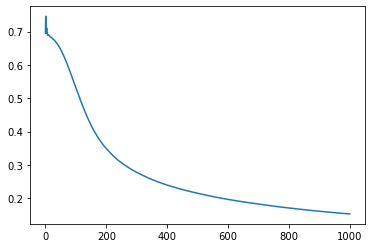

total time = 84.39092206954956


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.02,0.0519,0.0767,0.0299


In [ ]:
neuralNetworkClassificationCNN(data_1, data_2, Q_size = 20, lr_decay = 0.9, 
                               learning_rate = 2e-2, num_trials_maj = 1, 
                               out_channels = 10, kernel_size = 5, padding = 1, 
                               bias = True, Num_updates = 1000, D_out = 2, epoch = 50,
                               version = 'unsigned', sigma = 1, test_size = 0.3)

### Rand($v_Q^{\varsigma}$)

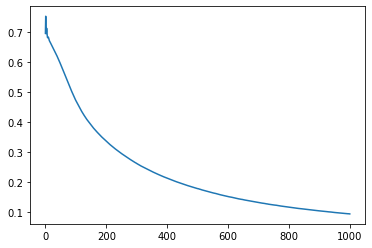

total time = 91.6853597164154


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.02,0.0259,0.1809,0.0331


In [ ]:
neuralNetworkClassificationCNN(data_1, data_2, Q_size = 20, lr_decay = 0.9, 
                               learning_rate = 2e-2, num_trials_maj = 1, 
                               out_channels = 10, kernel_size = 5, padding = 1, 
                               bias = True, Num_updates = 1000, D_out = 2, epoch = 50,
                               version = 'signed', sigma = 1, test_size = 0.3)

### Rand($v_Q^{exp}$)

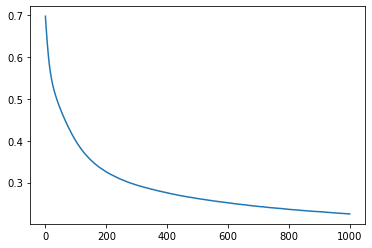

total time = 81.91993403434753


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.1097,0.1507,0.0743


In [ ]:
neuralNetworkClassificationCNN(data_1, data_2, Q_size = 20, lr_decay = 0.9, 
                               learning_rate = 1e-2, num_trials_maj = 1, 
                               out_channels = 10, kernel_size = 5, padding = 1, 
                               bias = True, Num_updates = 1000, D_out = 2, epoch = 50,
                               version = 'exp', sigma = 1, test_size = 0.3)

## maj_num = 11

### Vote($v_Q$)

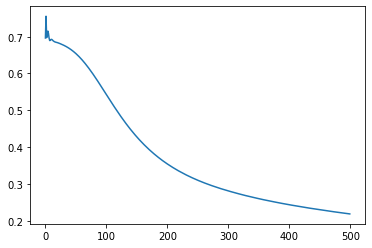

total time = 519.2008728981018


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.02,0.0745,0.0906,0.0287


In [ ]:
neuralNetworkClassificationCNN(data_1, data_2, Q_size = 20, lr_decay = 0.9, 
                               learning_rate = 2e-2, num_trials_maj = 11, 
                               out_channels = 10, kernel_size = 5, padding = 1, 
                               bias = True, Num_updates = 500, D_out = 2, epoch = 50,
                               version = 'unsigned', sigma = 1, test_size = 0.3)

### Vote($v_Q^{\varsigma}$)

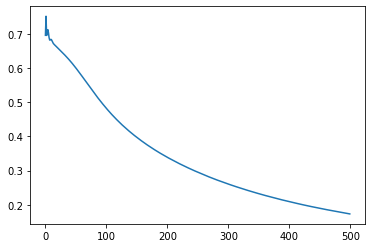

total time = 660.5302510261536


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.02,0.0539,0.1918,0.0359


In [ ]:
neuralNetworkClassificationCNN(data_1, data_2, Q_size = 20, lr_decay = 0.9, 
                               learning_rate = 2e-2, num_trials_maj = 11, 
                               out_channels = 10, kernel_size = 5, padding = 1, 
                               bias = True, Num_updates = 500, D_out = 2, epoch = 50,
                               version = 'signed', sigma = 1, test_size = 0.3)

### Vote($v_Q^{exp}$)

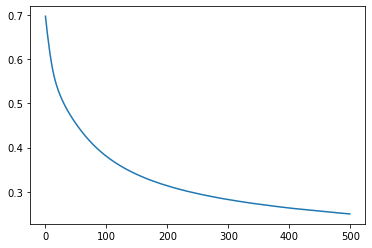

total time = 552.0694262981415


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.1186,0.1549,0.0561


In [ ]:
neuralNetworkClassificationCNN(data_1, data_2, Q_size = 20, lr_decay = 0.9, 
                               learning_rate = 1e-2, num_trials_maj = 11, 
                               out_channels = 10, kernel_size = 5, padding = 1, 
                               bias = True, Num_updates = 500, D_out = 2, epoch = 50,
                               version = 'exp', sigma = 1, test_size = 0.3)

# Neural Network for Mistake Driven Method of Choosing $Q$

## Initialize $Q$

In [ ]:
def initialize_Q(train_1, train_2, std_coeff, out_channels, kernel_size, Q_size, 
                 padding, learning_rate = 1e-3, bias = True, D_out=2, lr_decay = 0.9, 
                 Num_updates = 100): 
        
    Q = []
    errors = []
    losses = np.zeros((Q_size - kernel_size, Num_updates))
    
    mu = get_mu(train_1, train_2)
    std = mu * std_coeff

    trajectory_train_data = np.concatenate((train_1, train_2), axis = 0)
    train_labels = np.concatenate(([1] * len(train_1), [0] * len(train_2)), 0)
    train_labels = torch.from_numpy(train_labels).long()
    index = np.random.randint(0, high=len(trajectory_train_data)) 
    k = np.random.randint(0, high=len(trajectory_train_data[index]))
    for i in range(kernel_size):
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)

    for i in range(Q_size - kernel_size):
        train_data = ExpCurve2Vec(np.array(Q), trajectory_train_data, mu)
        model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                            out_channels = out_channels, 
                            kernel_size = kernel_size,
                            stride  = 1,
                            padding = padding,
                            bias = bias),
                nn.ReLU(),
                #nn.LeakyReLU(0.01),
                #nn.Tanh(),
                Flatten(),
                nn.Linear(out_channels * (len(train_data[0]) - kernel_size + 1 + 2 * padding), 
                            D_out)
                )
    
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        
        train_data = torch.from_numpy(train_data).float()
        train_data = train_data.view(len(train_data), 1, len(train_data[0]))
        
        for k in range(Num_updates):
            x_pred = model(train_data) # of shape (N, D_out)
            loss = loss_fn(x_pred, train_labels)
            losses[i, k] = loss
            
            if (k+1) % 100 == 0:
                optimizer.param_groups[0]['lr'] = lr_decay * learning_rate
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
        
        train_pred = torch.argmax(model(train_data), axis=1)
        scores = model(train_data)
        I = np.where((train_labels == train_pred) == False)[0]

        temp_labels = 2 * train_labels.numpy().reshape(len(train_labels.numpy()), 1) - 1
        temp = temp_labels * scores.detach().numpy()
        temp = np.max(temp, axis=1)
        index = I[np.argmax(temp[I])]

        error = sum(train_labels != train_pred)/len(train_labels)
        errors.append(error.item())
        
        k = np.random.randint(0, high=len(trajectory_train_data[index]))
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)

    final_error = errors[-1]

    #plt.plot((np.mean(losses, axis=0)))
    #plt.show()

    return np.array(Q), np.array(errors), mu, final_error


In [ ]:
def MD_NeuralNetworkClassificationCNN(data_1, data_2, maj_num, epoch, init_iter, 
                                      test_size, std_coeff, out_channels, kernel_size, 
                                      Q_size, padding, learning_rate = 1e-3, 
                                      bias = True, D_out=2, lr_decay = 0.9, 
                                      Num_updates = 100):
        
    start_time = time.time()

    train_errors = np.zeros(epoch) 
    test_errors = np.zeros(epoch)

    n_1 = len(data_1)
    n_2 = len(data_2) 

    for s in range(epoch):
        train_idx_1, test_idx_1, train_label_1, test_label_1, train_idx_2, \
        test_idx_2, train_label_2, test_label_2 = train_test(data_1, data_2, test_size)

        train = np.concatenate((data_1[train_idx_1], data_2[train_idx_2]), 0)
        test = np.concatenate((data_1[test_idx_1], data_2[test_idx_2]), 0)
        train_labels = np.concatenate((train_label_1, train_label_2), axis = 0)
        test_labels = np.concatenate((test_label_1, test_label_2), axis = 0)
        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()

        x_preds = torch.zeros((maj_num, len(train)))
        y_preds = torch.zeros((maj_num, len(test)))
        
        I = np.arange(len(train))
        np.random.shuffle(I)
        train = train[I]
        train_labels = train_labels[I]
        
        J = np.arange(len(test))
        np.random.shuffle(J)
        test = test[J]
        test_labels = test_labels[J]

        for t in range(maj_num):

            Q_list = []
            temp_errors = []
            mu_temp = []

            for j in range(init_iter):
                B = initialize_Q(data_1[train_idx_1], data_2[train_idx_2], 
                                 std_coeff, out_channels, kernel_size, Q_size, 
                                 padding, learning_rate = 1e-3, bias = True, 
                                 D_out=2, lr_decay = 0.9, Num_updates = 100)

                Q_list.append(B[0])
                mu_temp.append(B[2])
                temp_errors.append(B[-1])

            h = np.argmin(temp_errors)
            Q = Q_list[h]
            mu = mu_temp[h]

            train_data = torch.from_numpy(ExpCurve2Vec(Q, train, mu)).float()
            train_data = train_data.view(len(train_data), 1, len(train_data[0]))

            test_data = torch.from_numpy(ExpCurve2Vec(Q, test, mu)).float()
            test_data = test_data.view(len(test_data), 1, len(test_data[0]))

            model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                    nn.ReLU(),
                    #nn.LeakyReLU(0.01),
                    #nn.Tanh(),
                    Flatten(),
                    nn.Linear(out_channels * (len(train_data[0][0]) - kernel_size + 1 + 2 * padding), 
                              D_out)
                    )
        
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        
            for k in range(Num_updates):
                x_pred = model(train_data) # of shape (N, D_out)
                loss = loss_fn(x_pred, train_labels)

                if (k+1) % 10 == 0:
                    optimizer.param_groups[0]['lr'] = lr_decay * learning_rate
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step() 

            scores = model(train_data)
            
            x_preds[t] = torch.argmax(scores, axis=1)
            y_preds[t] = torch.argmax(model(test_data), axis=1)

        x_preds = torch.tensor(find_majority_array(x_preds))
        y_preds = torch.tensor(find_majority_array(y_preds))

        train_errors[s] = sum(abs(train_labels - x_preds))/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds))/len(test_labels)

    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    Dict = {"CNN 1-Layer": [out_channels, learning_rate, 
                            np.round(train_error_mean, decimals = 4), 
                            np.round(test_error_mean, decimals = 4),
                            np.round(test_error_std, decimals = 4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                                 columns=['Channel 1', 'Learning Rate', 
                                          'Train Error', 'Test Error', 'Std Error'])

    print(colored(f"total time = {time.time() - start_time}", "red"))
    print("mu =", mu)

    return pdf


## num_maj = 1

In [ ]:
MD_NeuralNetworkClassificationCNN(data_1, data_2, maj_num = 1, epoch = 50, init_iter = 3,
                                  test_size=0.3, std_coeff=1, out_channels=10, 
                                  kernel_size = 5, Q_size = 20, padding = 1, 
                                  learning_rate = 1e-2, bias = True, D_out=2, 
                                  lr_decay = 0.9, Num_updates = 1000)

total time = 624.0325717926025
mu = 0.006521448222319037


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0759,0.1243,0.0664


## num_maj = 11

In [ ]:
MD_NeuralNetworkClassificationCNN(data_1, data_2, maj_num = 11, epoch=50, init_iter=3, 
                                  test_size=0.3, std_coeff=1, out_channels=10, 
                                  kernel_size = 5, Q_size = 20, padding = 1, 
                                  learning_rate = 1e-2, bias = True, D_out=2, 
                                  lr_decay = 0.9, Num_updates = 500)

total time = 5361.949270963669
mu = 0.010480723465386532


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.1113,0.137,0.0692


# Plot test errors

In [ ]:
A_LSVM = [0.1573, 0.1716, 0.3733, 0.0887, 0.1993, 0.1960, 0.3991, 0.2649, 0.4013]
A_GSVM = [0.0464, 0.0675, 0.1142, 0.1384, 0.0682, 0.0851, 0.1555, 0.1443, 0.0697]
A_PSVM = [0.0530, 0.3109, 0.2836, 0.2119, 0.0658, 0.3219, 0.3143, 0.2158, 0.2075]
A_DT = [0.0888, 0.0678, 0.1027, 0.0781, 0.1266, 0.1128, 0.1503, 0.1257, 0.0967]
A_RF = [0.0578, 0.0536, 0.0875, 0.0622, 0.0752, 0.0660, 0.0975, 0.0918, 0.0649]
A_KNN = [0.0733, 0.0858, 0.2175, 0.0888, 0.1069, 0.0861, 0.2488, 0.1519, 0.0916]
A_LR = [0.2207, 0.4452, 0.4324, 0.2321, 0.2673, 0.4252, 0.4182, 0.2864, 0.5096]
A_CNN = [0.1370, 0.0906, 0.1918, 0.1549, 0.1243, 0.0767, 0.1809, 0.1507, 0.4949]

A = np.array([A_LSVM, A_GSVM, A_PSVM, A_DT, A_RF, A_KNN, A_LR, A_CNN])
B = A.T

In [ ]:
std_LSVM = [0.0435, 0.0252, 0.0423, 0.0395, 0.0390, 0.0418, 0.0433, 0.0567, 0.0378]
std_GSVM = [0.0186, 0.0224, 0.0300, 0.0388, 0.0338, 0.0237, 0.0303, 0.0752, 0.0229]
std_PSVM = [0.0323, 0.1131, 0.0379, 0.0555, 0.0388, 0.1057, 0.0456, 0.0789, 0.0422]
std_DT = [0.0237, 0.0196, 0.0251, 0.0230, 0.0300, 0.0237, 0.0312, 0.0500, 0.0278]
std_RF = [0.0225, 0.0186, 0.0222, 0.0213, 0.0277, 0.0207, 0.0263, 0.0483, 0.0224]
std_KNN = [0.0292, 0.0271, 0.0318, 0.0276, 0.0398, 0.0231, 0.0448, 0.0556, 0.0231]
std_LR = [0.0365, 0.0522, 0.0398, 0.0386, 0.0523, 0.0482, 0.0452, 0.0628, 0.0312]
std_CNN = [0.0692, 0.0287, 0.0359, 0.0561, 0.0664, 0.0299, 0.0331, 0.0743, 0.0075]

C = np.array([std_LSVM, std_GSVM, std_PSVM, std_DT, std_RF, std_KNN, std_LR, std_CNN]).T

In [ ]:
# for KNN
errors = [0.0949, 0.1037, 0.0903, 0.1130, 0.1240, 0.1131, 0.3013, 0.0828, 0.2084, 
          0.1652, 0.2891, 0.1070]

stds = [0.0344, 0.0329, 0.0306, 0.0360, 0.0315, 0.0283, 0.0508, 0.0256, 0.0448, 
        0.0332, 0.0732, 0.0271]

In [ ]:
classifiers = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'CNN']

FM = (r'KNN', r'Vote(MD $v_Q^{exp}$)', r'Vote(Rand $v_Q$)', r'Vote($v_Q^{\varsigma}$)', 
      r'Vote(Rand $v_Q^{exp}$)', r'MD $v_Q^{exp}$', r'Rand $v_Q$', 
      r'Rand $v_Q^{\varsigma}$', r'Rand $v_Q^{exp}$', 'Endpoints')

labels = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'CNN']

dists = [r'$d_F$', r'$d_{dF}$', r'$dH$', r'DTW', r'soft-dtw', r'fastdtw', 
         r'LCSS', r'SSPD', r'EDR', r'ERP', r'LSH', r'$d_Q^{\pi}$']

In [ ]:
def lower_limit_error(x, y):
    if y - x < 0:
        return y
    else:
        return x

lower_limit_error = np.vectorize(lower_limit_error)

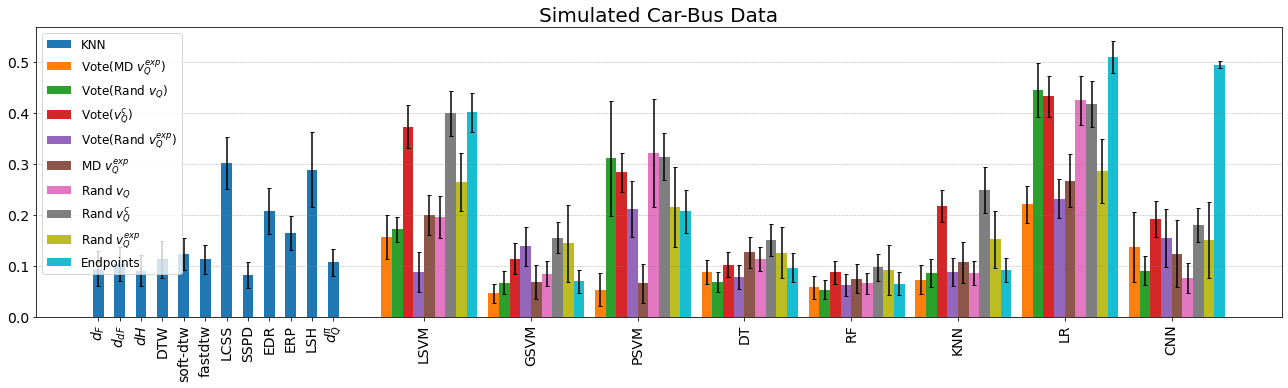

In [ ]:
width=0.1
index = np.arange(len(stds))
ind = np.arange(len(A)) + len(index) * 0.25

plt.subplots(figsize = (18, 5.5), tight_layout=True)
bars = [0] * 10

lower_lim = lower_limit_error(stds, errors)
bars[0] = plt.bar(index * 0.2, errors, width, yerr=[lower_lim, stds], capsize=2)

for i in range(len(FM)-1):
    lower_limit = lower_limit_error(C[i], B[i])
    bars[i+1] = plt.bar(ind+width*i-0.3, B[i], width, yerr=[lower_limit, C[i]], capsize=2)

plt.title('Simulated Car-Bus Data', fontsize = 20)
plt.xticks(list(np.arange(len(stds)) * 0.2) + list(ind + 0.5 * width), 
           dists + labels, fontsize = 14)

plt.legend(tuple(bars), FM, loc=0, fontsize = 12)

plt.gca().yaxis.grid(color='gray', linestyle='dotted', linewidth=0.6)
plt.xticks(rotation='vertical', fontsize = 14)
plt.yticks(fontsize = 14)

path = '/content/gdrive/My Drive/Colab Notebooks/plots/plots simulated car-bus/simulated car-bus bar chart all horizontal.png'

plt.savefig(path, bbox_inches='tight', dpi=200)

plt.show()
